## Sequence Space Jacobian
State-Space perturbation methods (like Reiter) require us to perturb an incredibly high dimensional object of agent states in order to solve a model with more levels of heterogeneity, which can be very computationally inefficient. Instead, we can use a sequence space method, which perturbs around the path for the exogenous variables and the aggregates, which, generally, is much smaller. This is the same idea we used to solve the RBC model in 1.

The limitations to this method is that it requires us to assume shocks have a finite time horizon of effect, and that eventually the economy returns to the steady state, not just approaches it. Also, it requires us to feed the entire exogenous sequence into the algorithm. These turn out to not be significant limitations. After 300-1000 time periods (depending on the persistence of the model), shock effects have generally completely dissipated, so assuming they've gone away isn't a problem. Also, linearized state-space and sequence-space methods get the same result (nonlinear methods will be different because of precautionary saving households do when there is a potential for larger shocks) for shocks at $t=0$ and sequence-space methods can also model news shocks, like when the FED says they plan to increase interest rates in the future.

#### Preliminaries

In [1]:
## load some packages
from scipy.optimize import brentq
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt
from scipy import sparse
import numba as nb
import numpy as np

## config
# params
ALPHA = 1/3
BETA = 0.98
GAMMA = 2.
DELTA = 0.05
A_MIN = 0.  # borrowing constraint
PRODUCTIVITY = np.array([1, 2.5])  # low and high productivity
L_L = 0.4  # probability of staying low
H_H = 0.8  # probability of staying high
TRAN_MAT = np.array([[L_L, 1-H_H], [1-L_L, H_H]])  # transition matrix
RHO_Z = 0.9
SIGMA_Z = 0.02

# grids
A_MAX = 500
N_A = 501
GRID = np.linspace(A_MIN**0.25, A_MAX**0.25, N_A)**4

#### The Model
The model is identical to the one used for the MIT shocks.

The model is populated by a unit continuum of households indexed $i \in [0, 1]$. The households have preferences given by
$$
    \mathbb{E} \sum_{t=0}^\infty \beta^t \frac{c_{i, t}^{1-\gamma}}{1-\gamma}
$$
subject to the budget constraint
$$
    b_{i, t} + c_{i, t} = R_t b_{i, t-1} + W_t z_{i, t}
$$
where $z_{i, t}$ represents the household's productivity which transitions idiosyncratically between $z_\ell$ and $z_h$ where $z_\ell < z_h$ with transition probabilities given by $\Pi(z_{i, t} \mid z_{i, t-1})$ and borrowing constraint $b_{i, t} > \underline b$.

The households therefore solves the Lagrangian
$$
    \mathcal{L} = \mathbb{E} \sum_{t=0}^\infty \beta^t \left(\frac{c_{i, t}^{1-\gamma}}{1-\gamma} + \lambda_{i, t} \left(R_t b_{i, t-1} + W_t z_{i, t} - b_{i, t} - c_{i, t}\right) + \mu_{i, t} \left( \underline b - b_{i, t}\right)\right)
$$
which has the FOCs
\begin{align*}
    \lambda_{i, t} &= c_{i, t}^{-\gamma} \tag{$c_{i, t}$} \\
    \lambda_{i, t} &= \beta \mathbb{E} R_{t+1} \lambda_{i, t+1} + \mu_{i, t} \tag{$b_{i, t}$}
\end{align*}
Combined, these get the Euler Equation
$$
    c_{i, t}^{-\gamma} \geq \beta \mathbb{E} R_{t+1} c_{i, t+1}^{-\gamma}
$$
which holds with equality whenever the borrowing constraint isn't binding.

The firm has the production function
$$
    Y_t = Z_t K_t^\alpha L_t^{1-\alpha}
$$
which combining the FOCs and the depreciation rate of capital gets
\begin{align*}
    R_t &= \alpha Z_t K_t^{1-\alpha} L_t^{1-\alpha} + 1 - \delta \\
    W_t &= (1-\alpha) Z_t K_t^\alpha L_t^{-\alpha}
\end{align*}
where $Z_t$ is the productivity shock with evolves according to
$$
    \log Z_t = \rho_Z \log Z_{t-1} + \varepsilon_Z
$$
and $\varepsilon_Z \sim \mathcal{N} (0, \sigma_Z)$.

Finally, we'll define aggregators such that
\begin{align*}
    K_t = \int_0^1 b_{i, t} di \\
    L_t = \int_0^1 z_{i, t} di.
\end{align*}

| Variable | Meaning |
| --- | --- |
| $c_{i, t}$ | Household $i$'s consumption at time $t$ |
| $b_{i, t}$ | Household $i$'s investments at the end of time $t$ |
| $z_{i, t}$ | Household $I$'s productivity at time $t$ |
| $Y_t$ | Output at time $t$ |
| $K_t$ | Capital stock at time $t$ |
| $L_t$ | Labor at time $t$ |
| $R_t$ | Return on capital holdings at time $t$ |
| $W_t$ | Wage at time $t$ |
| $Z_t$ | Aggregate productivity at time $t$ |

| Parameter | Meaning |
| --- | --- |
| $\alpha$ | Cobb-Douglas parameter |
| $\beta$ | Household discount factor |
| $\gamma$ | Household rick aversion |
| $\delta$ | Depreciation rate of capital |
| $\rho_Z$ | Productivity regression to mean |
| $\sigma_Z$ | Productivity shock size |
| $\underline b$ | Borrowing constraint |
| $\Pi$ | Transition probabilities |

#### Labor
In the model, labor is unaffected by any economic variables and only by idiosyncratic shocks. Therefore, we can solve for it here and treat it as a parameter going forward.

In [2]:
# get distribution
vals, vecs = np.linalg.eig(TRAN_MAT)
i = np.abs(vals).argmax()  # dominant eigenvactor
L_dist = vecs[:, i]
L_dist /= L_dist.sum()

# aggregate
L = PRODUCTIVITY @ L_dist

#### Economy
The economic variables including prices and output are a function of the capital stock in the last period and productivity now. Therefore, we'll characterize our economy using only these two values and solve for the other values based on these each period.

In [3]:
@nb.njit
def get_aggs(K_l, Z_t=1., L_t=L):  # 1 is steady state Z
    '''
    Solve for W, R, and Y given a capital value
    '''
    R_t = ALPHA * Z_t * K_l**(ALPHA-1) * L_t**(1-ALPHA) + 1 - DELTA
    W_t = (1-ALPHA) * Z_t  * K_l**ALPHA * L_t**(-ALPHA)
    Y_t = Z_t * K_l**ALPHA * L_t**(1-ALPHA)

    return R_t, W_t, Y_t

#### EGM
The endogenous grid method is the same, we just need to be slightly more careful with time subscripts. It now will solve for end of last period assets $b_{i, t-1}$ (and thereby this period's production function) given this period's end of period assets $b_{i, t}$ and the next period's savings function $g_{t+1}$.

We do this by solving

\begin{align*}
    \mathbb{E} c_{i, t+1} &= \mathbb{E} \left[R_{t+1} b_{i, t} + W_{t+1} z_{i, t+1} - g_{t+1} (b_{i, t}, z_{i, t+1}) \right] \\
    c_{i, t} &= \left(\beta \mathbb{E} R_{t+1} c_{i, t+1}^{-\gamma}\right)^\frac{-1}{\gamma} \\
    b_{i, t-1} &= \frac{1}{R_t} \left(b_{i, t} + c_{i, t} - W_t z_{i, t}\right)
\end{align*}

In [4]:
@nb.njit
def linear_interpolation(x, y, X):  # helper numberical methods function we need
    '''
    Performs a linear interpolation of x and y at X
    '''
    # setuo
    n = len(x)

    # create and return interpolation
    idx = np.minimum(np.maximum(np.searchsorted(x, X, 'right'), 1), n-1)  # min an max make sure that points before/after end up on a line
    x_l = x[idx-1]  # values below the x
    y_l = y[idx-1]
    x_h = x[idx]  # values above the x
    y_h = y[idx]
    m = (y_h - y_l) / (x_h - x_l)  # slope
    return y_l + m * (X - x_l)  


@nb.njit
def g_interp(a, a_t, a_p=GRID):  # gets a savings funciton g
    '''
    Savings function for a given a_t maps to a_p
    '''
    # setup
    num_endows = a_t.shape[1]

    # interpolate
    a_pr = np.empty(a_t.shape)
    for i in nb.prange(num_endows):
        a_pr[:, i] = linear_interpolation(a_t[:, i], a_p, a)
    
    # borrowing constraint
    for i in nb.prange(a_pr.shape[0]):
        for j in nb.prange(a_pr.shape[1]):
            if a_pr[i, j] < A_MIN:
                a_pr[i, j] = A_MIN
    
    return a_pr


@nb.njit
def euler_back(g_p, R_t, W_t, R_p, W_p, b_t=GRID, exog_tran_mat=TRAN_MAT, productivity=PRODUCTIVITY):  # egm core
    '''
    Finds a savings function given a old guess for a savings function
    and gridpoitns

    g_p shold be the savings levels now that map to the gird points 
    '''
    c_p = R_p * b_t[:, None] + W_p * productivity - g_interp(b_t, g_p)  # get next period consumption
    expec_dc_p = c_p ** (-GAMMA) @ exog_tran_mat  # take expectation with deriavtive
    c_t = (BETA * R_p * expec_dc_p)**(-1/GAMMA)  # consumption now
    b_l = 1/R_t * (b_t[:, None] + c_t - W_t * productivity)  # savings at the start of the period

    return b_l

#### Transition Matrix
We want to make a transition matrix for wealth and idiosyncratic shocks so we can track the distribution along the gridpoints.

In [5]:
@nb.njit
def make_tran_mat_vectors(b_t, b_l=GRID, exog_tran_mat=TRAN_MAT):
    '''
    Makes the wealth distribution transition matrix givena savings rule
    from each of the gridpoints. Returns the data, row, and column matricies
    to make a sparse matrix for it, not the matrix itself
    '''
    # figure out where values go
    idxs = np.minimum(np.searchsorted(b_l, b_t, 'right'), N_A-1)  # upper of the two adjacent indicies to where g maps
    p_l = np.empty(b_t.shape)
    for i in nb.prange(idxs.shape[0]):
        for j in nb.prange(idxs.shape[1]):
            idx = idxs[i, j]
            p_l[i, j] = max((b_l[idx] - b_t[i, j]) / (b_l[idx] - b_l[idx-1]), 0.)
    # # 1 -> it maps to the lower girdpoint, 0 -> it maps to the higher girdpoint, 0.5 -> its halfway between both
    p_h = 1 - p_l  # how close it is to the upper half

    # create transition matricies
    # low efficiency: capital now -> capital later
    data_l = np.concatenate((p_l[:, 0], p_h[:, 0]))
    mask_l = data_l != 0  # there can be zeros when a point perfectly matches a girdpoint
    data_l = data_l[mask_l]
    row_l = np.concatenate((idxs[:, 0]-1, idxs[:, 0]))[mask_l]
    col_l = np.concatenate((np.arange(N_A), np.arange(N_A)))[mask_l]

    # high efficicency: capital now -> capital later
    data_h = np.concatenate((p_l[:, 1], p_h[:, 1]))
    mask_h = data_h != 0  # there can be zeros when a point perfectly matches a girdpoint
    data_h = data_h[mask_h]
    row_h = np.concatenate((idxs[:, 1]-1, idxs[:, 1]))[mask_h]
    col_h = np.concatenate((np.arange(N_A), np.arange(N_A)))[mask_h]

    # create overall transition matrix
    data = np.concatenate((
            data_l * exog_tran_mat[0, 0], data_l * exog_tran_mat[1, 0],
            data_h * exog_tran_mat[0, 1], data_h * exog_tran_mat[1, 1],
        ))
    row = np.concatenate((
            row_l, N_A + row_l,  # top vector (employed) is on top
            row_h, N_A + row_h,
        ))
    col = np.concatenate((
            col_l, col_l,  # left half of transition matrix 
            N_A + col_h, N_A + col_h,  # right half of transition matrix
        ))
    
    return data, row, col


def make_tran_mat(b_t):
    '''
    Makes the transition matrix for idiosyncratic shocks and wealth levels for
    households
    '''
    data, row, col = make_tran_mat_vectors(b_t)
    tran_mat = sparse.csr_array((data, (row, col)), shape=(N_A*2, N_A*2))  # sparse array cant be jit compiled

    return tran_mat

#### Aggregator
We'll aggregate the distribution to find a new option for $K$.

In [6]:
@nb.njit
def agg_K(dist, grid=GRID):
    return (grid * dist.T).sum()

#### Steady State
We'll use the methods implemented in the last notebook to find the steady state for the economy.

In [7]:
@nb.njit
def egm(b_l, R, W, max_iter=10000, tol=1e-14):
    for _ in range(max_iter):
        # get new consumption function
        last_b_l = b_l
        b_l = euler_back(b_l, R, W, R, W)

        # exit condition
        diff = np.abs(b_l - last_b_l).max()
        if diff < tol:
            break
    else:
        print('Policy Rule: Max iteration count exceeded')
    
    return b_l


def get_dist(b_t):
    '''
    Use the eignevector of a sparse matrix to find the stationary distribution
    of capital
    '''
    # get transition matrix
    tran_mat = make_tran_mat(b_t)

    # use eigenvalues to get the steady state distribution of capital
    dist = sparse.linalg.eigs(tran_mat, k=1)[1].real  # get dominant eigenvector
    dist /= dist.sum()  # normalize to sume to 1
    dist = dist.reshape((-1, 2), order='F')  # reshape to keep track of labor efficiency state, first column is low, second is high

    return dist, tran_mat

## seperate blocks so jit stuff stays compiled

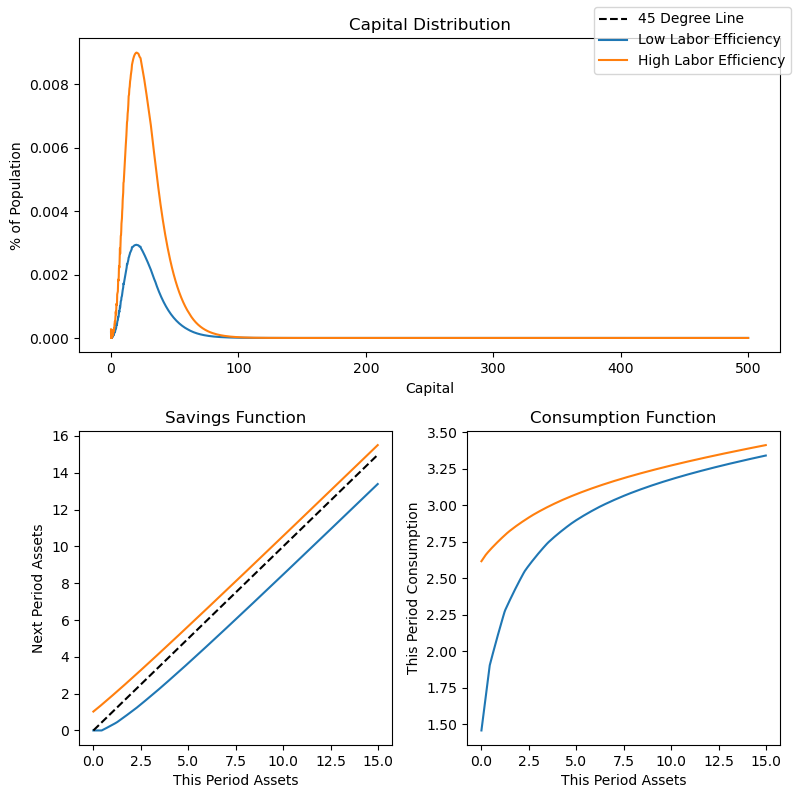

In [8]:
b_l0 = 10 + 0.1 * np.tile(GRID, PRODUCTIVITY.shape+(1,)).T  # intial guess we make here and update in the function to make the next iteration faster
def simulate_K(K, grid=GRID, b_l0=b_l0):
    R, W, Y = get_aggs(K)  # aggregate variables
    b_l = egm(b_l0, R, W)  # use the egm to solve for a policy rule
    b_l0[:] = b_l  # make next iteration faster
    dist, tran_mat = get_dist(g_interp(grid, b_l))  # get the distribution of capital
    K_d = agg_K(dist)

    return K_d, R, W, Y, b_l, dist, tran_mat


# params
capital_max_iter = 100  # max number of gueses for capital
capital_tol = 1e-10  # actual capital will be within this distance of capital
K_0 = ((1/BETA + DELTA - 1) / ALPHA / L**(1-ALPHA))**(1/(ALPHA-1))  # steady state RBC K
K_ss = brentq(lambda K: simulate_K(K)[0] - K, K_0, K_0+2., xtol=capital_tol, maxiter=capital_max_iter)
_, R_ss, W_ss, Y_ss, b_l_ss, dist_ss, tran_mat_ss = simulate_K(K_ss)
g_ss = lambda b_l: g_interp(b_l, b_l_ss)
c_ss = lambda b_l: R_ss*b_l[:, None] + W_ss*PRODUCTIVITY - g_ss(b_l)

# setup plot
fig, axs = plt.subplots(2, 2)
fig.set_figwidth(8)
fig.set_figheight(8)
gs = axs[0, 0].get_gridspec()
for ax in axs[0, :]:  # remove the axis so we can have one big one
    ax.remove()
axtop = fig.add_subplot(gs[0, :])
axtop.set_title('Capital Distribution')
axtop.set_xlabel('Capital')
axtop.set_ylabel('% of Population')
axs[1, 0].set_title('Savings Function')
axs[1, 0].set_xlabel('This Period Assets')
axs[1, 0].set_ylabel('Next Period Assets')
axs[1, 1].set_title('Consumption Function')
axs[1, 1].set_xlabel('This Period Assets')
axs[1, 1].set_ylabel('This Period Consumption')

# plot it
axtop.plot(GRID, dist_ss[:, 0], label='Low Labor Efficiency')
axtop.plot(GRID, dist_ss[:, 1], label='High Labor Efficiency')
n = (GRID < 15).sum()  # look at first n gridpoits, most the interesting stuff happens early
axs[1, 0].plot(GRID[:n], g_ss(GRID)[:n])
axs[1, 0].plot([A_MIN, GRID[n-1]], [A_MIN, GRID[n-1]], 'k--', label='45 Degree Line')
axs[1, 1].plot(GRID[:n], c_ss(GRID)[:n])

# final things
fig.legend()
fig.tight_layout()

#### Sequence Space Jacobian Method
To solve for a IRF for the model, we first assume the economy starts at the steady state at $t=0$ and is back to the steady state at $t=T$ and express the model as a function
$$
    F(\mathbf{X}, \mathbf{Z}) = \vec 0
$$
where $\mathbf{X}$ is a vector of aggregate states (in our case $\{K_t\}_{t=0}^T$) and $\mathbf{Z}$ is the vector of aggregate shocks ($\{Z_t\}_{t=0}^T$). Then, we find the Jacobians $F_\mathbf{X}$ and $F_\mathbf{Z}$ and the IRF for aggregates becomes
$$
    \mathbf{X} = \mathbf{X}_{ss} - F_{\mathbf{X}}^{-1} F_{\mathbf{Z}} (\mathbf{Z} - \mathbf{Z}_{ss})
$$

The key insight is that the actions of the distribution of agents are decided within $F$, not an input to the function. This makes it a much smaller system, but does make it harder to calculate the initial Jacobians.

In our case, the function $F$ will be the market clearing conditions for capital - that the amount of capital implied by the distribution of household wealth $\tilde K_t$ is equal to the amount of capital $K_t$. Since household actions are a function of $W_t$ and $R_t$, this can be written more formally as
$$
    \tilde K_t(\{R_s, W_s\}_{s \geq 0}^T) - K_t = 0
$$
where $\tilde K_t$ takes prices at $s$ to create household decision rules which adjust the distribution of wealth from the steady state at time 0 to $t$.

For a given $t, s$ entry, we know
\begin{align*}
    [F_{\mathbf{X}}]_{t, s} &= \frac{\partial (\tilde K_t - K_t)}{\partial K_s} \\
    &= \frac{\partial \tilde K_t}{\partial K_s} - \frac{\partial K_t}{\partial K_s} \\
    &= \frac{\partial \tilde K_t}{\partial R_{s+1}} \frac{\partial R_{s+1}}{\partial K_s} + \frac{\partial \tilde K_t}{\partial W_{s+1}} \frac{\partial W_{s+1}}{\partial K_s} - 1_{s=t}
\end{align*}
and
\begin{align*}
    [F_{\mathbf{Z}}]_{t, s} &= \frac{\partial (\tilde K_t - K_t)}{\partial Z_s} \\
    &= \frac{\partial \tilde K_t}{\partial Z_s} - \frac{\partial K_t}{\partial Z_s} \\
    &= \frac{\partial \tilde K_t}{\partial R_{s+1}} \frac{\partial R_{s+1}}{\partial Z_s} + \frac{\partial \tilde K_t}{\partial W_{s+1}} \frac{\partial W_{s+1}}{\partial Z_s}
\end{align*}
where
\begin{align*}
    \frac{\partial R_{s+1}}{\partial K_s} &= \alpha (\alpha-1) Z_{s+1} K_s^{\alpha-2} L^{1-\alpha} \\
    \frac{\partial W_{s+1}}{\partial K_s} &= \alpha (1-\alpha) Z_{s+1} K_s^{\alpha-1} L^{-\alpha} \\
    \frac{\partial R_s}{\partial Z_s} &= \alpha K_{s-1}^{\alpha-1} L^{1-\alpha} \\
    \frac{\partial W_s}{\partial Z_s} &= (1-\alpha) K_{s-1}^\alpha L^{-\alpha}.
\end{align*}
Since we'll want the Jacobian around the steady state, these all become constants.

Therefore, the problem becomes finding the Jacobians $\frac{\partial \tilde K}{\partial R}$ and $\frac{\partial \tilde K}{\partial W}$.

In [9]:
# shock params
T = 500

# shock path
Z_ss = 1.
Z_path = Z_ss + SIGMA_Z * np.full(T, RHO_Z) ** np.arange(T)  # linearized (no exp)

#### Fake News Algorithm
To solve for the Jacobians we'll use the Fake News Algorithm. The key to this algorithm is to recognize that the policy function at time $t$ assuming a shock at time $s$ follows
$$
    g_t^s = \begin{cases} g_{ss} \quad \text{if } s < t \\ g_{T-1-(s-t)}^{T-1} \quad \text{otherwsie} \end{cases}
$$
meaning we can find all policy functions $g_t^s$ from a single backwards iteration assuming a shock at time $T-1$. Since transition matrices come from policy functions, that means we can also solve for all transition matrices.




Altogether, the algorithm goes:
1. Backwards iterate from $t=T-1$ to $t=0$ finding $g_0^s$ at each $s$. Using this, we also create the transition matrix $\Pi_0^s$ for wealth. Then, letting $d g$ be the change in the policy function and $d \Pi$ be the change in the transition matrix, calculate
$$
    \mathcal{Y}_s = \frac{d g_0^s D_{ss}}{dx}
$$
representing the effect of a shock at $s$ on output at 0 and
$$
    \mathcal{D}_s = \frac{d \Pi_0^s D_{ss}}{dx}
$$
representing the change in the initial distribution of wealth given a shock at time $s$.

2. Calculate the expectation vectors
$$
    \mathcal{E}_t = \Pi_{ss}^{\top t} g_{ss}
$$
representing the expected outputs at time $t$ from each point on the wealth distribution at time $0$.

3. Create the "Fake News" matrix $\mathcal{F}$ defined as
$$
    \mathcal{F} = \begin{pmatrix}
        \mathcal{Y}_0 & \mathcal{Y}_1 & \mathcal{Y}_2 & \dots & \mathcal{Y}_{T-1} \\
        \mathcal{E}_0 \cdot \mathcal{D}_0 & \mathcal{E}_0 \cdot \mathcal{D}_1 & \mathcal{E}_0 \cdot \mathcal{D}_2 & \dots & \mathcal{E}_0 \cdot \mathcal{D}_{T-1} \\
        \mathcal{E}_1 \cdot \mathcal{D}_0 & \mathcal{E}_1 \cdot \mathcal{D}_1 & \mathcal{E}_1 \cdot \mathcal{D}_2 & \dots & \mathcal{E}_1 \cdot \mathcal{D}_{T-1} \\
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        \mathcal{E}_{T-2} \cdot \mathcal{D}_0 & \mathcal{E}_{T-2} \cdot \mathcal{D}_1 & \mathcal{E}_{T-2} \cdot \mathcal{D}_2 & \dots & \mathcal{E}_{T-2} \cdot \mathcal{D}_{T-1} \\
    \end{pmatrix}
$$

4. Create the Jacobian $\mathcal{J}$ using that $\mathcal{J}_{t, s} = \mathcal{J}_{t-1, s-1} + \mathcal{F}_{t, s}$.

In [25]:
def back_iter(i, T=T, b_l_ss=b_l_ss, dist_ss=dist_ss, tran_mat_ss=tran_mat_ss, R_ss=R_ss, W_ss=W_ss, h=1e-7, grid=GRID):
    '''
    Backwards iterate to make the distributions and output effects at each time
    '''
    # setup
    d_input = np.array([R_ss, W_ss]) + np.eye(1, 2, i)[0] * h  # perturb input
    curly_Y = np.empty(T)  # curly_Y[s] represents effect on aggregates at time 0 on shock at time s
    curly_D = np.empty((T, len(grid), 2))  # curly_D[s] represents effect on period 1 distribution of shock at time s
    corrected_b_l = euler_back(b_l_ss, R_ss, W_ss, R_ss, W_ss)  # subtract this out each period so the steady state stays centered

    # get initial period, pertubed R_t or W_t
    db_l = euler_back(b_l_ss, *d_input, R_ss, W_ss) - corrected_b_l  # we subtract corrected_b_l to avoid numerical errors from an imperfect steady state (idk if this works tbh)
    b_t = g_interp(grid, b_l_ss + db_l)
    curly_Y[0] = ((b_t - grid[:, None]) * dist_ss).sum() / h
    dtran_mat = make_tran_mat(b_t) - tran_mat_ss  # cant be njited
    curly_D[0] =  (dtran_mat @ dist_ss.ravel('F')).reshape((-1, 2), order='F') / h

    # get second period, perturbed R_p or W_p
    db_l = euler_back(b_l_ss + db_l, R_ss, W_ss, *d_input) - corrected_b_l  # we subtract corrected_b_l to avoid numerical errors from an imperfect steady state (idk if this works tbh)
    b_t = g_interp(grid, b_l_ss + db_l)
    curly_Y[1] = ((b_t - grid[:, None]) * dist_ss).sum() / h
    dtran_mat = make_tran_mat(b_t) - tran_mat_ss
    curly_D[1] =  (dtran_mat @ dist_ss.ravel('F')).reshape((-1, 2), order='F') / h

    # get later periods, R_ss and W_ss
    for s in range(2, T):
        db_l = euler_back(b_l_ss + db_l, R_ss, W_ss, R_ss, W_ss) - corrected_b_l  # we subtract corrected_b_l to avoid numerical errors from an imperfect steady state (idk if this works tbh)
        b_t = g_interp(grid, b_l_ss + db_l)
        curly_Y[s] = ((b_t - grid[:, None]) * dist_ss).sum() / h
        dtran_mat = make_tran_mat(b_t) - tran_mat_ss
        curly_D[s] =  (dtran_mat @ dist_ss.ravel('F')).reshape((-1, 2), order='F') / h

    return curly_Y, curly_D


def expect_vectors(tran_mat_ss=tran_mat_ss, b_l_ss=b_l_ss, grid=GRID, T=T):
    '''
    Find expected vectors
    '''
    # initialize
    curly_E = np.empty((T-1, len(GRID), 2))  # curly_E[s] represents expected output at time s

    # expect = transition matrix * wher eyou exepcetd to be last period
    curly_E[0] = g_interp(grid, b_l_ss)  # how much they decide to spend (known now)
    for t in range(1, T-1):
        curly_E[t] = (tran_mat_ss.T @ curly_E[t-1].ravel('F')).reshape((-1, 2), order='F')

    return curly_E


@nb.njit
def fake_news(curly_Y, curly_D, curly_E, T=T):
    '''
    Make the fake news matrix from the curlys
    '''
    # initialize and assign top row
    fake_news_mat = np.empty((T, T))
    fake_news_mat[0] = curly_Y

    # make bottom rows
    for s in range(T-1):
        for t in range(T):
            fake_news_mat[s+1, t] = (curly_E[s] * curly_D[t]).sum()

    return fake_news_mat


@nb.njit
def jacobian_from_fake_news(fake_news_mat):
    '''
    Make the jacobian from the fake news matrix
    '''
    # initialize it with the fake news matrix, we'll add elemtns to iteself to make the jacobians
    jacobian = 1. * fake_news_mat

    # add down the diaganel
    for i in range(1, jacobian.shape[0]):
        jacobian[i, 1:] += jacobian[i-1, :-1]
    
    return jacobian


def get_jacobians(h=1e-7, n_x=2, T=T, b_l_ss=b_l_ss, dist_ss=dist_ss, tran_mat_ss=tran_mat_ss, R_ss=R_ss, W_ss=W_ss, grid=GRID):
    '''
    Find the jacobians (and fake new matricies) from the vectors
    '''
    # colelct results here
    jacobians = []
    fake_news_mats = []

    # get expectaions (contant for all varibales we take it with respect to)
    curly_E = expect_vectors(tran_mat_ss=tran_mat_ss, b_l_ss=b_l_ss, grid=grid, T=T)

    # get each variables jacobian
    for i in range(n_x):
        curly_Y, curly_D = back_iter(i, T=T, b_l_ss=b_l_ss, dist_ss=dist_ss, tran_mat_ss=tran_mat_ss, R_ss=R_ss, W_ss=W_ss, h=h, grid=grid)
        fake_news_mat = fake_news(curly_Y, curly_D, curly_E, T=T)
        fake_news_mats.append(fake_news_mat)
        jacobians.append(jacobian_from_fake_news(fake_news_mat))
    
    return jacobians, fake_news_mats

# break to keep jits compiled

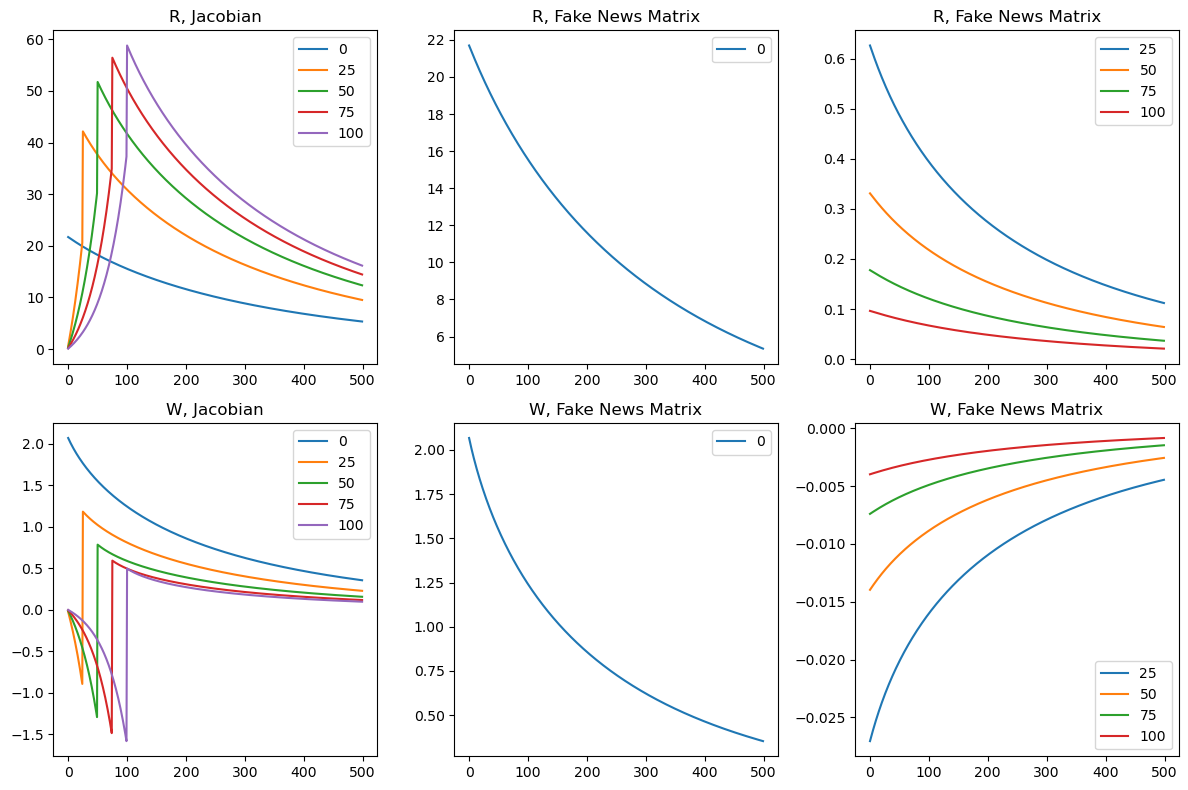

In [26]:
# get the jacobians
jacobians, fake_news_mats = get_jacobians()  # order is R, W within each

# plot columns
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(12)
fig.set_figheight(8)
axs[0, 0].set_title('R, Jacobian')
axs[0, 1].set_title('R, Fake News Matrix')
axs[0, 2].set_title('R, Fake News Matrix')
axs[1, 0].set_title('W, Jacobian')
axs[1, 1].set_title('W, Fake News Matrix')
axs[1, 2].set_title('W, Fake News Matrix')

# times we'll have a line for
ts = np.arange(0, 101, 25)

# plot jacobians
axs[0, 0].plot(jacobians[0][:, ts], label=ts)
axs[1, 0].plot(jacobians[1][:, ts], label=ts)

# plot zero time fake news matrix
axs[0, 1].plot(fake_news_mats[0][:, 0], label=0)
axs[1, 1].plot(fake_news_mats[1][:, 0], label=0)

# plot later time fake news matrix
axs[0, 2].plot(fake_news_mats[0][:, ts[1:]], label=ts[1:])
axs[1, 2].plot(fake_news_mats[1][:, ts[1:]], label=ts[1:])

# final things
for i in range(axs.size):
    axs.take(i).legend()
fig.tight_layout()

#### Make G
We'll define
$$
    \mathbf{G} = -F_\mathbf{K}^{-1} F_\mathbf{Z}
$$
which lets us have a solution to the problem. To find $\mathbf{G}$, we'll need to use the expressions we found earlier for $F_\mathbf{K}$ and $F_\mathbf{Z}$ from the Jacobians with respect to $R$ and $W$ around the steady state. Then, we'll multiply them.

In [12]:
@nb.njit
def get_derivs(K_ss=K_ss, Z_ss=Z_ss):
    '''
    Gets the derivates of R, W, and Y with respect to K and Z
    '''
    dRdK = ALPHA * (ALPHA - 1) * Z_ss * K_ss**(ALPHA-2) * L**(1-ALPHA)
    dWdK = ALPHA * (1 - ALPHA) * Z_ss * K_ss**(ALPHA-1) * L**(-ALPHA)
    dYdK = ALPHA * Z_ss * K_ss**(ALPHA-1) * L**(1-ALPHA)
    dRdZ = ALPHA * K_ss**(ALPHA-1) * L**(1-ALPHA)
    dWdZ = (1 - ALPHA) * K_ss**(ALPHA) * L**(-ALPHA)
    dYdZ = K_ss**ALPHA * L**(1-ALPHA)

    return dRdK, dWdK, dYdK, dRdZ, dWdZ, dYdZ


@nb.njit
def get_G(J_R, J_W, Z_ss=Z_ss, K_ss=K_ss):
    '''
    Make the impulse response solution matrix
    '''
    # get static derivatives
    dRdK, dWdK, _, dRdZ, dWdZ, _ = get_derivs(K_ss, Z_ss)

    # get jacobians
    F_K = J_R * dRdK + J_W * dWdK - np.eye(T)  # idk if this deals with time right
    F_Z = J_R * dRdZ + J_W * dWdZ

    # get G
    G = -np.linalg.solve(F_K, F_Z)

    return G

# break to keep jits compiled

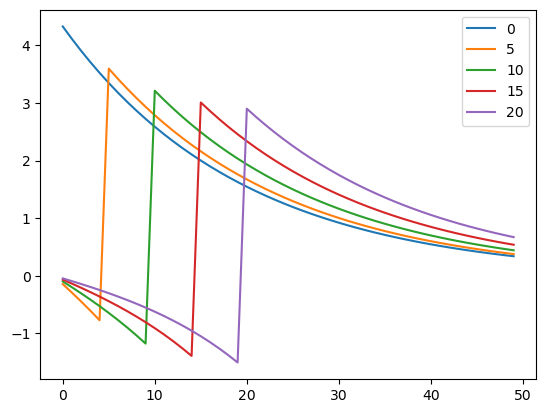

In [13]:
# get the results
G = get_G(*jacobians)

# plot the columns of G
ts = np.arange(0, 25, 5)
plt.plot(G[:50, ts], label=ts)
plt.legend()

#### Impulse Response
To get an impulse response for aggregates, it's as simple as solving
$$
    \vec K = \vec K_{ss} + G (\vec Z - \vec Z_{ss}).
$$
Then, we can solve for other aggregates or with a bit of work get the distribution.

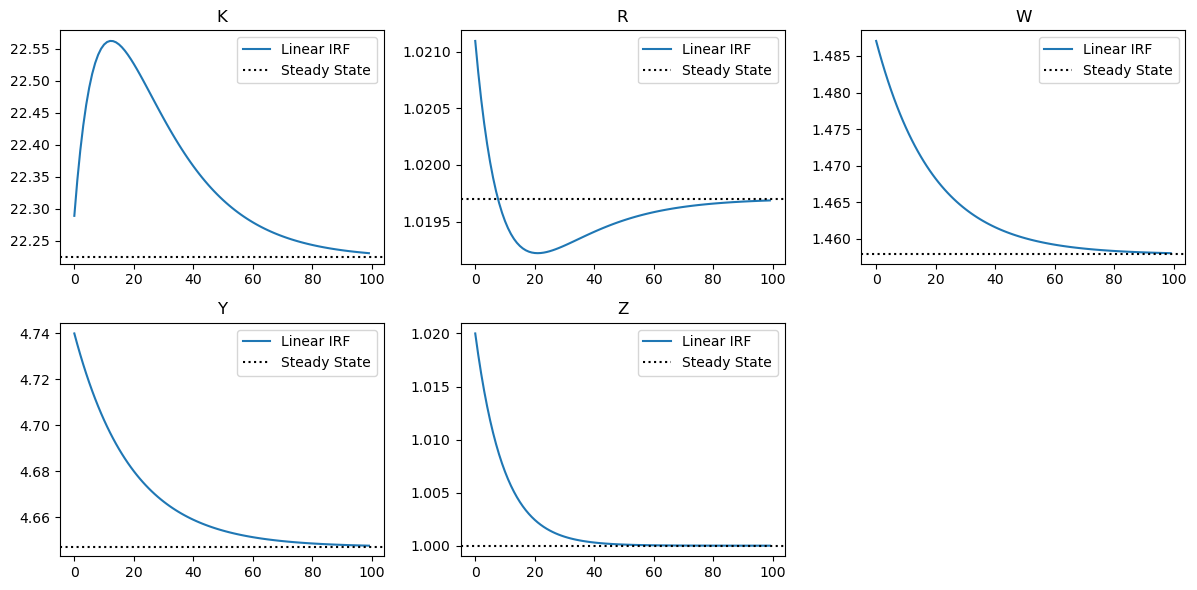

In [14]:
# solve for K
dZ_path = Z_path - Z_ss
dK_path = G @ dZ_path

# get other paths, we use a linear extension since everyhting were doing is linearized
dRdK, dWdK, dYdK, dRdZ, dWdZ, dYdZ = get_derivs()  # derivitaives around steady state
dR_path = dZ_path * dRdZ + np.hstack((0, dK_path[:-1])) * dRdK  # do i treat K_l correct here?
dW_path = dZ_path * dWdZ + np.hstack((0, dK_path[:-1])) * dWdK
dY_path = dZ_path * dYdZ + np.hstack((0, dK_path[:-1])) * dYdK
K_path = K_ss + dK_path
R_path = R_ss + dR_path
W_path = W_ss + dW_path
Y_path = Y_ss + dY_path

# plot it
t = 100
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(12)
fig.set_figheight(6)
titles = ['K', 'R', 'W', 'Y', 'Z']
paths = [K_path, R_path, W_path, Y_path, Z_path]
X_ss = [K_ss, R_ss, W_ss, Y_ss, Z_ss]
for i in range(5):
    ax = axs.take(i)
    ax.plot(paths[i][:t], label='Linear IRF')
    ax.axhline(X_ss[i], color='k', linestyle=':', label="Steady State")
    ax.set_title(titles[i])
    ax.legend()
axs.take(5).set_axis_off()
fig.tight_layout()

#### Policy Functions
To simulate the changes to the policy functions and distribution of wealth over time, we simply need to do the same thing, but keep track of $d \Pi$ and $d g$ instead of $d \mathcal{Y}$ and $d \mathcal{D}$.

Then, to find $d D$ we use

\begin{align*}
    d D_t^s &= \Pi_{ss} d D_{t-1}^s + d \Pi_{t-1}^s D_{ss} \\
    &= \left(\sum_{n=0}^{t-1} \Pi_{ss}^{t-1-n} d \Pi_n^s\right) D_{ss}
\end{align*}

In [15]:
def policy_back_iter(i, T=T, b_l_ss=b_l_ss, tran_mat_ss=tran_mat_ss, R_ss=R_ss, W_ss=W_ss, h=1e-7, grid=GRID):
    '''
    Backwards iterate to make the distributions and output effects at each time
    '''
    # setup
    d_input = np.array([R_ss, W_ss]) + np.eye(1, 2, i)[0] * h  # perturb input
    db_l_path = np.empty((T, len(grid), 2))  # db_l_path[s] represents the effect on policy functions at time 0 of a shock at time s
    dtran_mat_path = []  # dtran_mat_path[s] represeants the effect on transition probabilities at time 0 of a shock at time s
    corrected_b_l = euler_back(b_l_ss, R_ss, W_ss, R_ss, W_ss)  # subtract this out each period so the steady state stays centered

    # get initial period, pertubed R_t or W_t
    db_l = euler_back(b_l_ss, *d_input, R_ss, W_ss) - corrected_b_l  # we find db_l to avoid numerical errors from an imperfect steady state (idk if this works tbh)
    db_l_path[0] = db_l / h
    b_t = g_interp(grid, b_l_ss + db_l)
    dtran_mat = make_tran_mat(b_t) - tran_mat_ss  # cant be njited
    dtran_mat_path.append(dtran_mat / h)

    # get second period, perturbed R_p or W_p
    db_l = euler_back(b_l_ss + db_l, R_ss, W_ss, *d_input) - corrected_b_l  # we find db_l to avoid numerical errors from an imperfect steady state (idk if this works tbh)
    db_l_path[1] = db_l / h
    b_t = g_interp(grid, b_l_ss + db_l)
    dtran_mat = make_tran_mat(b_t) - tran_mat_ss
    dtran_mat_path.append(dtran_mat / h)

    # get later periods, R_ss and W_ss
    for s in range(2, T):
        db_l = euler_back(b_l_ss + db_l, R_ss, W_ss, R_ss, W_ss) - corrected_b_l  # we find db_l to avoid numerical errors from an imperfect steady state (idk if this works tbh)
        db_l_path[s] = db_l / h
        b_t = g_interp(grid, b_l_ss + db_l)
        dtran_mat = make_tran_mat(b_t) - tran_mat_ss
        dtran_mat_path.append(dtran_mat / h)

    return db_l_path, np.array(dtran_mat_path)


def get_dvar_path(dvar_X, dX_path, T=T):
    '''
    Applys chain rule to get the path for some variables based on its derivative with respect to X
    '''
    # chain rule matrix
    chain = np.zeros((T, T))
    rows, tri_cols = np.triu_indices(T)
    cols = tri_cols - np.repeat(np.arange(T), T-np.arange(T))  # adjust to left side
    chain[rows, cols] = dX_path[tri_cols]

    # make path
    dvar_path = (dvar_X.T @ chain).T

    return dvar_path


def get_ddist_path(dtran_mat_path, tran_mat_ss=tran_mat_ss, dist_ss=dist_ss, T=T):
    '''
    Create the path for the changes in the distribution
    '''
    ddist_path = np.empty((T,) + dist_ss.shape)  # db_l_path[s] represents the effect on policy functions at time 0 of a shock at time s

    # create path
    ddist_path[0] = (dtran_mat_path[0] @ dist_ss.ravel('F')).reshape((-1, 2), order='F')
    for t in range(1, T):
        ddist_path[t] = (tran_mat_ss @ ddist_path[t-1].ravel('F') + dtran_mat_path[t] @ dist_ss.ravel('F')).reshape((-1, 2), order='F')

    return ddist_path


# get rules
db_l_R, dtran_mat_R = policy_back_iter(0)
db_l_W, dtran_mat_W = policy_back_iter(1)

# get paths
db_l_path = get_dvar_path(db_l_R, dR_path) + get_dvar_path(db_l_W, dW_path)
dtran_mat_path = get_dvar_path(dtran_mat_R, dR_path) + get_dvar_path(dtran_mat_W, dW_path)  # this line takes most the time here
ddist_path = get_ddist_path(dtran_mat_path)
dist_path = dist_ss + ddist_path
b_l_path = b_l_ss + db_l_path

In [16]:
# animation
# setup plot
n = (GRID <= 50).sum()  # look at first n gridpoits, most the interesting stuff happens early
fig, axs = plt.subplots(2, 2)
fig.suptitle('t=0')
fig.set_figwidth(8)
fig.set_figheight(8)
gs = axs[0, 0].get_gridspec()
for ax in axs[0, :]:  # remove the axis so we can have one big one
    ax.remove()
axtop = fig.add_subplot(gs[0, :])
axtop.set_title('Wealth Distribution')
axtop.set_xlabel('Wealth')
axtop.set_ylabel('% of Population')
axtop.set_xlim((A_MIN, A_MAX))
axtop.set_ylim((0, 1.1*max([d.max() for d in dist_path])))
axs[1, 0].set_title('Savings Function')
axs[1, 0].set_xlabel('This Period Assets')
axs[1, 0].set_ylabel('% Deviation from Steady State')
axs[1, 0].set_xlim((A_MIN, GRID[n-1]))
axs[1, 0].axhline(0., color='k', linestyle=':')
axs[1, 1].set_title('Consumption Function')
axs[1, 1].set_xlabel('This Period Assets')
axs[1, 1].set_ylabel('% Deviation from Steady State')
axs[1, 1].set_xlim((A_MIN, GRID[n-1]))
axs[1, 1].axhline(0., color='k', linestyle=':')

# plot it
ln_dist_low, = axtop.plot([], [], label='Low Endowment')
ln_dist_high, = axtop.plot([], [], label='High Endowment')
ln_g_low, = axs[1, 0].plot([], [])
ln_g_high, = axs[1, 0].plot([], [])
ln_c_low, = axs[1, 1].plot([], [])
ln_c_high, = axs[1, 1].plot([], [])

# final things
fig.legend()
fig.tight_layout()

# update frame
def update(t):
    fig.suptitle(f't={t}')

    # update distribution
    dist_t = dist_path[t]
    ln_dist_low.set_data(GRID, dist_t[:, 0])
    ln_dist_high.set_data(GRID, dist_t[:, 1])

    # update savings
    b_l = b_l_path[t]
    g_t = lambda b: g_interp(b, b_l)
    savings = (g_t(GRID) - g_ss(GRID)) / np.where(g_ss(GRID) != 0, g_ss(GRID), 1.)
    ln_g_low.set_data(GRID[:n], savings[:n, 0])
    ln_g_high.set_data(GRID[:n], savings[:n, 1])

    # update consumption
    c_t = lambda b: R_path[t]*b[:, None] + W_path[t]*PRODUCTIVITY - g_t(b)
    consumption = (c_t(GRID) - c_ss(GRID)) / c_ss(GRID)
    ln_c_low.set_data(GRID[:n], consumption[:n, 0])
    ln_c_high.set_data(GRID[:n], consumption[:n, 1])

# animate it
plt.close()  # dont show empty figure
anim = animation.FuncAnimation(fig, update, frames=100, interval=50, repeat=False)  # only look at first few hundred periods
HTML(anim.to_html5_video())

#### Simulation
To simulate a period of time, we'll use the fact that
$$
    d \tilde X_t = \sum_{s=0}^{T-1} d X_s \varepsilon_{t-s}.
$$
Essentially, the total effect at time $t$ is the effect on all shocks within the modeled time. Therefore, to simulate a period of time, we'll first generate our exogenous shocks, them calculate the effect of these shocks on the endogenous variables independently before we add them together. 

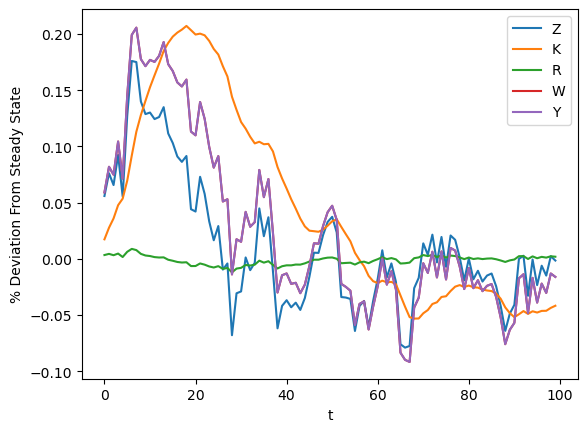

In [17]:
# config
np.random.seed(100)
sim_len = 100

# get epsilon
err_Z = np.random.normal(0, SIGMA_Z, sim_len+T+1)  # do T estra and discard first T since they weren't impacted by shocks before, 1 extra to deal with lags
sim_dZ_path = np.outer(RHO_Z**np.arange(T), err_Z)  # sim_Z_path[t] is the time path for Z resulting from the error introduced at t

# calculate K path
sim_dK_path = G @ sim_dZ_path

# flatten arrays
def flatten(sim_X_path, T=T):
    '''
    Get the actual path for a vairable given the path from t shocks
    '''
    flattened_path = sim_X_path[0, T:]  # skip first T rows to calibrate
    for i in range(1, T):
        flattened_path += sim_X_path[i, T-i:-i]
    return flattened_path
sim_dZ_path = flatten(sim_dZ_path)
sim_dK_path = flatten(sim_dK_path)

# get other vars
sim_dR_path = sim_dZ_path[1:] * dRdZ + sim_dK_path[:-1] * dRdK  # do i treat K_l correct here?
sim_dW_path = sim_dZ_path[1:] * dWdZ + sim_dK_path[:-1] * dWdK
sim_dY_path = sim_dZ_path[1:] * dYdZ + sim_dK_path[:-1] * dYdK
sim_dK_path = sim_dK_path[1:]
sim_dZ_path = sim_dZ_path[1:]

# plot the results
plt.xlabel('t')
plt.ylabel('% Deviation From Steady State')
plt.plot(sim_dZ_path, label='Z')
plt.plot(sim_dK_path / K_ss, label='K')
plt.plot(sim_dR_path / R_ss, label='R')
plt.plot(sim_dW_path / W_ss, label='W')
plt.plot(sim_dY_path / Y_ss, label='Y')
plt.legend()